In [1]:
import logging
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
%matplotlib inline

In [2]:
from iSDM.species import IUCNSpecies
turtles = IUCNSpecies(name_species='Pelusios rhodesianus')
turtles.load_shapefile('../data/FW_TURTLES/FW_TURTLES.shp')

Loading data from: ../data/FW_TURTLES/FW_TURTLES.shp
The shapefile contains data on 181 species.


In [3]:
turtles.find_species_occurrences()

Loaded species: ['Pelusios rhodesianus'] 


,binomial,category,citation,class_name,compiler,dist_comm,family_nam,genus_name,geometry,id_no,...,presence,seasonal,shape_area,shape_leng,source,species_na,subpop,subspecies,tax_comm,year
156,Pelusios rhodesianus,LR/lc,CRF,REPTILIA,Rhodin,None,PELOMEDUSIDAE,Pelusios,(POLYGON ((12.44598388671875 -6.02496337890625...,16530.0,...,1.0,1.0,341.941542,248.22574,CBFTT,rhodesianus,None,None,None,2013.0


In [4]:
type(turtles)

iSDM.species.IUCNSpecies

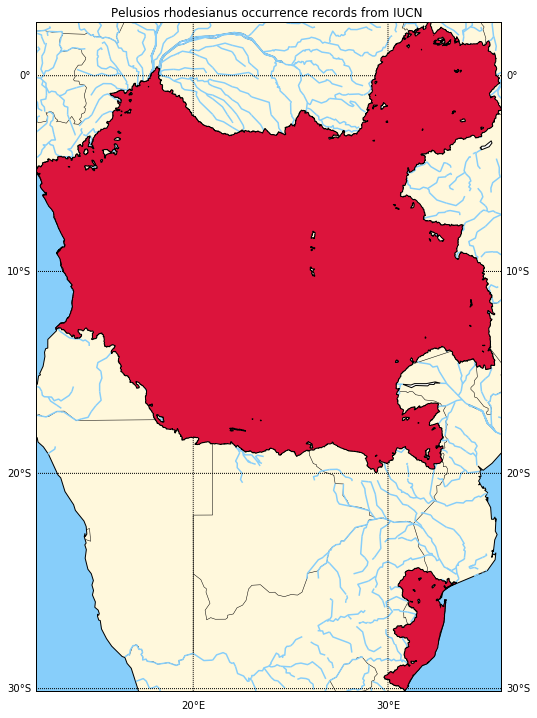

In [5]:
turtles.plot_species_occurrence()

In [6]:
turtles.save_shapefile("../data/filtered_turtles_again.shp")

Saved data: ../data/filtered_turtles_again.shp 


In [22]:
from iSDM.environment import ClimateLayer
worldclim_alt =  ClimateLayer(file_path="../data/tmax1/tmax6.bil") 
worldclim_alt.load_dataset()

Loading data from ../data/tmax1/tmax6.bil 
Metadata: {'affine': Affine(0.041666666666667, 0.0, -180.00000000000335,
       0.0, -0.041666666666667, 90.00000000000003),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'EHdr',
 'dtype': 'int16',
 'height': 3600,
 'nodata': -9999.0,
 'transform': (-180.00000000000335,
               0.041666666666667,
               0.0,
               90.00000000000003,
               0.0,
               -0.041666666666667),
 'width': 8640} 
Resolution: (0.041666666666667, 0.041666666666667) 
Bounds: BoundingBox(left=-180.00000000000335, bottom=-60.000000000001165, right=179.9999999999995, top=90.00000000000003) 
Dataset loaded. Use .read() or .read_masks() to access the layers.


<open RasterReader name='../data/tmax1/tmax6.bil' mode='r'>

In [10]:
worldclim_alt.reproject(destination_file="../data/reprojected.adf", resolution=1, driver='AIG')

Calculated default transformation:
Affine:
| 1.00, 0.00,-180.00|
| 0.00,-1.00, 90.00|
| 0.00, 0.00, 1.00| 
 width=361, height=151
Reprojected data in ../data/reprojected.adf 


In [25]:
worldclim_alt.load_dataset("../data/reprojected.adf")

Loading data from ../data/reprojected.adf 
Metadata: {'affine': Affine(1.0, 0.0, -180.000000000003,
       0.0, -1.0, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'EHdr',
 'dtype': 'int16',
 'height': 151,
 'nodata': -9999.0,
 'transform': (-180.000000000003, 1.0, 0.0, 90.0, 0.0, -1.0),
 'width': 361} 
Resolution: (1.0, 1.0) 
Bounds: BoundingBox(left=-180.000000000003, bottom=-61.0, right=180.999999999997, top=90.0) 
Dataset loaded. Use .read() or .read_masks() to access the layers.


<open RasterReader name='../data/reprojected.adf' mode='r'>

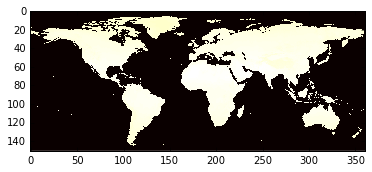

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(worldclim_alt.get_data().read(1), cmap="hot", interpolation="none")

In [32]:
from __future__ import print_function

import numpy
#import numpy.stats.mstats
import fiona
import rasterio
import rasterio.features
from affine import Affine
from shapely.geometry import shape

with fiona.open("../data/filtered_turtles_again.shp", 'r') as vector, \
     rasterio.open("../data/tmax1/tmax6.bil", 'r') as raster:

    for feature in vector:
        # create a shapely geometry
        # this is done for the convenience for the .bounds property only
        geometry = shape(feature['geometry'])

        # get pixel coordinates of the geometry's bounding box
        ul = raster.index(*geometry.bounds[0:2])
        lr = raster.index(*geometry.bounds[2:4])

        # read the subset of the data into a numpy array
        window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
        data = raster.read_band(1, window=window)

        # create an affine transform for the subset data
        t = raster.affine
        shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

        # rasterize the geometry
        mask = rasterio.features.rasterize(
            [(geometry, 0)],
            out_shape=data.shape,
            transform=shifted_affine,
            fill=1,
            all_touched=True,
            dtype=numpy.uint8)

        # create a masked numpy array
        masked_data = numpy.ma.array(data=data, mask=mask.astype(bool))

        # display some statistics
        #name = feature['properties']['NAME'].title()
        #print('{}\nRange: {:.1f} to {:.1f}'.format(
        #    name,
        #    masked_data.min(),
        #    masked_data.max()))

/home/daniela/anaconda/envs/biodiversity_py3/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: read_band() is deprecated and will be removed by Rasterio 1.0. Please use read() instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [62]:
masked_data[masked_data!=-9999].min()

86

In [63]:
masked_data.max()

330

In [64]:
masked_data.shape

(790, 574)

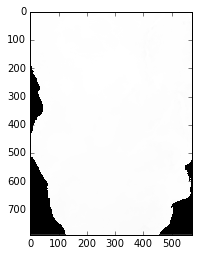

In [69]:
plt.imshow(masked_data.data, cmap="gray", interpolation="none")

In [59]:
masked_data.data.max()

338

In [65]:
masked_data.shape

(790, 574)

In [61]:
masked_data.data[masked_data.data!=-9999].min()

51

In [19]:
type(masked_data)

numpy.ma.core.MaskedArray

In [20]:
# let's get a bigger region
turtles.load_shapefile('../data/FW_TURTLES/FW_TURTLES.shp')

Loading data from: ../data/FW_TURTLES/FW_TURTLES.shp
The shapefile contains data on 181 species.


In [31]:
type(turtles.data_full)

geopandas.geodataframe.GeoDataFrame

In [33]:
turtles.data_full.sort('shape_area')['shape_area']

/home/daniela/anaconda/envs/biodiversity_py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


24       0.011238
80       0.012925
151      0.084941
146      0.089625
115      0.117710
111      0.336232
71       0.342511
97       0.429037
51       0.512279
76       0.544609
158      0.617495
93       0.810781
152      0.933764
107      0.937060
25       0.957405
47       1.094181
149      1.159840
141      1.269961
18       1.401336
10       1.401881
84       1.438258
105      1.491718
106      1.631186
131      1.724558
77       1.775093
29       1.804453
32       1.870815
6        2.017690
112      2.088427
79       2.122132
          ...    
99     132.212201
36     133.719358
150    134.777414
78     147.767834
142    152.588574
17     156.126424
135    161.669016
4      172.597842
65     176.098873
180    177.743904
101    201.141294
15     201.904285
49     212.681864
155    219.276486
177    223.472883
161    225.234527
134    238.591600
129    259.458469
42     260.236717
87     272.206524
13     277.143417
46     313.360957
156    341.941542
50     359.439467
127    388

Self-intersection at or near point 33.433620922481026 1.7837054041947724
Self-intersection at or near point 33.433620922481026 1.7837054041947724


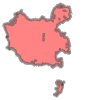

In [47]:
turtles.data_full.geometry[156]

In [46]:
turtles.data_full.iloc[156]

binomial                                   Pelusios rhodesianus
category                                                  LR/lc
citation                                                    CRF
class_name                                             REPTILIA
compiler                                                 Rhodin
dist_comm                                                  None
family_nam                                        PELOMEDUSIDAE
genus_name                                             Pelusios
geometry      (POLYGON ((12.44598388671875 -6.02496337890625...
id_no                                                     16530
island                                                     None
kingdom_na                                             ANIMALIA
legend                                                   Extant
order_name                                           TESTUDINES
origin                                                        1
phylum_nam                              